In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


## Загружаем данные

In [2]:
import os
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную 

# train_label.shape = (42000,)
train_label = train[:, 0]  # В нулевом столбце представлены конкретные цифры 
print('Размер обучающей разметки: ', train_label.shape)
# определяем, как будут представлены обучающая и тестовая картинки

# приводим размерность к удобному для обаботки виду
# размер train[:, 1:] = (42000, 784), размер train.shape[0] = 42000
# берем массив train[:, 1:] и представляем его в форме train.shape[0] (т.е. len(train) = 42000 строк 28*28)
# train.shape = (42000, 28, 28)

train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
print('Размер обучающей выборки: ', train_img.shape)
# test.shape = (28000, 784), test.shape[0] = 28000
# test_img.shape = (28000, 28, 28)
# предсталение test_img = (28000, 28, 28)

test_img = np.resize(test, (test.shape[0], 28, 28))
print('Размер тестовой выборки: ', test_img.shape)

Размер обучающей разметки:  (42000,)
Размер обучающей выборки:  (42000, 28, 28)
Размер тестовой выборки:  (28000, 28, 28)


## Визуализируем исходные данные

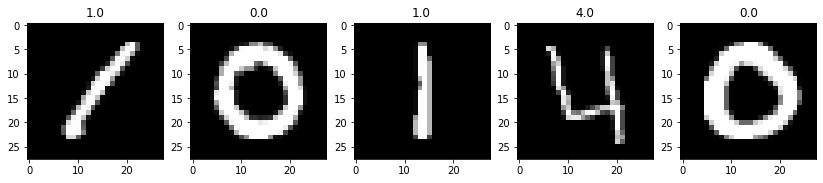

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
# в enumerate() второй аргумент (здесь 1) назначает нумерацию индекса 
# (здесь нулевому элементу присвоили именование 1, а не 0)
for i, img in enumerate(train_img[0:5], 1):
    # здесь (1,7,i) - это 1-я строка, 7-й столбец и i-тая (для каждой картинки своя i) ячейка на сетке Figure
    # чем больше вторая цифра (у нас она 7), тем мельче выводимое на печать изображение 
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    # [i-1] - т.к. индекс с нуля, и в такой системе пересчета 4-й элемент на самом деле третий
    subplot.set_title('%s' % train_label[i-1]);

## Стандартизируем данные
Пеобразуем данные в единичный масштаб (среднее = 0 и дисперсия = 1), что является требованием для оптимальной производительности многих алгоритмов машинного обучения

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_img = scaler.fit_transform(train[:, 1:])
test_img = scaler.fit_transform(test)

In [6]:
print(train_img.shape)
print(test_img.shape)

(42000, 784)
(28000, 784)


## Импортируем и применим модель PCA
Код имеет .95 для параметра количества компонентов. 
Это означает, что scikit-learn выбирает минимальное количество главных компонентов, чтобы сохранить 95% дисперсии

In [7]:
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(train_img)
pca.fit(test_img)

PCA(n_components=0.95)

In [8]:
print('Размерность тестовой выборки', test_img.shape)
print('Размерность обучающей выборки', train_img.shape)

Размерность тестовой выборки (28000, 784)
Размерность обучающей выборки (42000, 784)


In [9]:
# pca.transform() - уменьшим размерность изображения 
train_img = pca.transform(train_img)
test_img = pca.transform(test_img)

## Применим к данным модель логистической регрессии

In [10]:
train_label

array([1., 0., 1., ..., 7., 6., 9.])

In [11]:
from sklearn.linear_model import LogisticRegression

# для всех не указанных параметров устанавим значения по умолчанию
# solver по умолчанию невероятно медленный, поэтому его можно было бы изменить его на "lbfgs"
# однако есть трудности: 
logisticRegr = LogisticRegression(solver = 'liblinear')
logisticRegr.fit(train_img, train_label)

LogisticRegression(solver='liblinear')

In [12]:
print('Размерность тестовой выборки', test_img.shape)
print('Размерность обучающей выборки', train_img.shape)

Размерность тестовой выборки (28000, 315)
Размерность обучающей выборки (42000, 315)


## Предскажем метки новых данных (новые изображения)
Используем информацию, полученную моделью в процессе обучения модели.

In [13]:
# Код ниже предсказывает одно наблюдение
logisticRegr.predict(test_img[0].reshape(1,-1))

array([2.])

In [14]:
test_label = logisticRegr.predict(test_img)

In [15]:
# Код ниже предсказывает 5 наблюдений
test_label[0:5]

array([2., 0., 9., 7., 3.])

## Разбиваем выборку на обучение и валидацию

In [16]:
from sklearn.model_selection import train_test_split
y_train, y_val, X_train, X_val = train_test_split(
    train_label, train_img, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов


In [17]:
centroids = np.zeros((10, train_img.shape[1]), dtype=np.float32)

In [18]:
print(train_img.shape[1])
centroids

315


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
for i in range(10):
    centroids[i] = np.mean(X_train[y_train == i], axis=0)

## Находим ближайший центроид для валидации

In [20]:
# смотрим наименьшую дистанцию до соответствующей цифры 
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - X_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [21]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.8027380952380953


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.87      0.83      0.85       816
         1.0       0.75      0.97      0.85       909
         2.0       0.89      0.74      0.80       846
         3.0       0.77      0.78      0.78       937
         4.0       0.83      0.80      0.81       839
         5.0       0.75      0.68      0.71       702
         6.0       0.86      0.84      0.85       785
         7.0       0.92      0.81      0.86       893
         8.0       0.74      0.72      0.73       835
         9.0       0.72      0.82      0.76       838

    accuracy                           0.80      8400
   macro avg       0.81      0.80      0.80      8400
weighted avg       0.81      0.80      0.80      8400



Точность по класам вариативна: например, модель хорошо предсказывает семерки (92%), двойки (89%), нули (87%), шестерки (86%), четверки (83%). recall - сколько данной цифры модель нашла, support - количество таких объектов (например, семерок), f1-score - комбинация пресижн и рекол

In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[675   0   6   6   2  64  32   0  29   2]
 [  0 886   2   1   0   1   2   0  17   0]
 [ 20  40 622  34  31   5  33   8  48   5]
 [  5  39  28 735   3  23   8  11  55  30]
 [  8  26   6   0 673   6   9   1  12  98]
 [ 11  31  11  97  18 478  17   3  14  22]
 [ 35  37  11   1   9  19 662   0  11   0]
 [  2  46   3   2  17   2   0 725  14  82]
 [ 11  57  10  63  14  39   6   3 602  30]
 [ 12  25   2  13  47   4   0  41   9 685]]


Здесь выше представлен еще один способ посмотреть, что происходит с результатами: матрица невязки. По оси Х - предсказанные значения, по оси Y - актуальные значения

При идеальных предсказаниях - все большие значения должны быть на главной диагонали, все прочие позиции - нулевые

Первая строка отвечает за 0: как нули мы предсказываем цифру 675 раз, а как пятерку - 64 раза. То есть нули иногда путаются с пятерками, реже - с шестерками.

## Предсказания на тестовых данных

In [24]:
# инициализируем нулевой вектор предсказаний, чтобы затем заполнить его минимальной дистанцией
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_img[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

In [25]:
# fig = plt.figure(figsize=(20, 10))
# for i, img in enumerate(test_img[0:5], 1):
#     subplot = fig.add_subplot(1, 7, i)
#     plt.imshow(img, cmap='gray');
#     subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [26]:
# with open('submit.txt', 'w') as dst:
#     dst.write('ImageId,Label\n')
#     for i, p in enumerate(pred_test, 1):
#         dst.write('%s,%s\n' % (i, p))